### base test

In [1]:
item = 'random_smooth_efno'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.io as scio
import torch
import torch.nn as nn
from torchinfo import summary
from timeit import default_timer
import sys
sys.path.append("../scripts/")
sys.path.append("../run/")
import yaml
from utilities import *
# from deeponet_2d import *
from efno_2d import *
# from fourier_2d import *
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [3]:
cpu_num=1
os.environ['OMP_NUM_THREADS'] = str(cpu_num)
os.environ['OPENBLAS_NUM_THREADS'] = str(cpu_num)
os.environ['MKL_NUM_THREADS'] = str(cpu_num)
os.environ['VECLIB_MAXIMUM_THREADS'] = str(cpu_num)
os.environ['NUMEXPR_NUM_THREADS'] = str(cpu_num)
torch.set_num_threads(cpu_num)

In [4]:
cm = 1/2.54
plt.rcParams['font.family']       = 'arial' # 'Times New Roman' #
# plt.rcParams['axes.linewidth']    = 1
plt.rcParams['xtick.major.size']  = 2.
plt.rcParams['ytick.major.size']  = 2.5
plt.rcParams['xtick.minor.size']  = 1.5
plt.rcParams['ytick.minor.size']  = 1.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['lines.linewidth']   = 1.5
plt.rcParams['lines.markersize']  = 3.5

plt.rcParams['font.size']    = 10
# plt.rcParams['figure.titlesize'] = 2

plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize']  = 7 # x, y label size
plt.rcParams['axes.titlesize'] = 7 # font size of the axes title
# plt.rcParams['legend.fontsize'] = 8
# plt.rcParams['legend.title_fontsize'] = 8

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams['image.cmap'] = 'jet_r'
plt.rcParams['figure.dpi'] = 150

In [5]:
with open( '../run/config.yml') as f:
    config = yaml.full_load(f)
config = config[item]
device = torch.device('cpu')
TRAIN_PATH = config['TRAIN_PATH']
TEST_PATH  = config['TEST_PATH']
save_mode  = config['save_mode']
n_out      = config['n_out'] # rhoxy,phsxy,rhoyx,phsyx
model_path = "../model/"+config['name']+ "_"+str(n_out) # save path and name of model
model_path_temp = "../temp/"+config['name']+"_"+ str(n_out)
log_path = "../Log/"+config['name']+"_"+str(n_out)+'.log'

ntrain = config['ntrain']
ntest  = config['ntest']

batch_size = config['batch_size']
learning_rate = config['learning_rate']

epochs = config['epochs']
step_size = config['step_size']
gamma = config['gamma']

modes = config['modes']
width = config['width']

s_train = config['s_train']
r_train = config['r_train']
s_test = config['s_test']
r_test = config['r_test']
layer_num = config['layer_num']
last_size = config['last_size'] 
act_fno   = config['act_fno']

layer_sizes = config['layer_sizes']+[s_train[0]*s_train[1]]
act_func  = config['act_func']
init_func = config['init_func']
    

patience = config['patience'] # if there is {patience} epoch that val_error is larger, early stop,
thre_epoch = config['thre_epoch']# condiser early stop after {thre_epoch} epochs

print_model_flag = config['print_model_flag'] # 

In [6]:
loc_train,loc_test,train_loader, test_loader, x_normalizer,y_normalizer = \
get_batch_data(TRAIN_PATH, TEST_PATH, ntrain, ntest, r_train, s_train,r_test, s_test,batch_size,n_out)
data   = scio.loadmat(TEST_PATH)
zn     = data['zn'][0][::r_test[0]][:s_test[0]+1]
yn     = data['yn'][0][::r_test[1]][:s_test[1]+1]
freq   = data['freq'][0][::r_test[2]][:s_test[2]]
ry     = data['obs'][0][::r_test[3]][:s_test[3]]

begin to read data


/home/fengw666/.conda/envs/torch_radon/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


RuntimeError: shape '[3000, 64, 64, 1]' is invalid for input of size 3072000

In [ ]:
if os.path.exists(model_path+'.pt'):
    model=torch.load(model_path+'.pt',map_location=device)
elif os.path.exists(model_path+'.pkl'):
    model=deeponet(layer_sizes, act_func, init_func,modes, modes, width,\
        n_out,layer_num, last_size, act_fno).to(device)
    model.load_state_dict(torch.load(model_path+'.pkl',map_location=device))
else:
    raise RuntimeError('no model file')
myloss = LpLoss(size_average=False)

In [ ]:
model.eval()
model.to(device)
y_normalizer.to(device)
test_l2 = 0.0
# sample = next(iter(test_loader))
t1 = default_timer()
loc_test = loc_test.to(device)
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
#         T1 = default_timer()

        out = model(loc_test,x)#.reshape(batch_size, s[2],s[3],-1)
        input_size = s_test[2]*s_test[3]
        n_out = y.shape[-1]
        out = torch.cat(([out[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
                for i in range(n_out)]),-1)
        out = y_normalizer.decode(out)
#         T2 = default_timer()
#         print(T2-T1)

        test_l2 += myloss(out, y).item()

test_l2 /= ntest

t2 = default_timer()
print(t2-t1, test_l2)

RuntimeError: einsum(): subscript i has size 4096 for operand 1 which does not broadcast with previously seen size 1024

In [ ]:
freq_10 = data['freq'][0][::7][:10]
print(f"last freq point is {freq_10[-1]} Hz")
# model_path_10 = "../model/"+"random_10_64_3_"+str(n_out)
if os.path.exists(model_path+'.pt'):
    model_10=torch.load(model_path+'.pt',map_location=device)
elif os.path.exists(model_path+'.pkl'):
    model_10=deeponet(layer_sizes, act_func, init_func,modes, modes, width,\
        n_out,layer_num, last_size, act_fno).to(device)
    model_10.load_state_dict(torch.load(model_path+'.pkl',map_location=device))
else:
    raise RuntimeError('no model file')
myloss = LpLoss(size_average=False)

last freq point is 0.004999999999999999 Hz


In [ ]:


model_10.eval()
model_10.to(device)
y_normalizer.to(device)
test_l2 = 0.0
# sample = next(iter(test_loader))
t1 = default_timer()
loc_test = loc_test.to(device)
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        out_10 = model_10(loc_test,x)#.reshape(batch_size, s[2],s[3],-1)
        input_size = s_test[2]*s_test[3]
        n_out = y.shape[-1]
        out_10 = torch.cat(([out_10[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
                for i in range(n_out)]),-1)
        out_10 = y_normalizer.decode(out_10)

        test_l2 += myloss(out_10, y).item()

test_l2 /= ntest

t2 = default_timer()
print(t2-t1, test_l2)

49.77745481580496 0.009804984450340271


In [ ]:
sample = next(iter(test_loader))
t1 = default_timer()
loc_test = loc_test.to(device)
test_l2 = 0.0
with torch.no_grad():
    x, y = sample[0].to(device), sample[1].to(device)

    out = model(loc_test,x)#.reshape(batch_size, s[2],s[3],-1)
    input_size = s_test[2]*s_test[3]
    n_out = y.shape[-1]
    out = torch.cat(([out[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
            for i in range(n_out)]),-1)
    out = y_normalizer.decode(out)
#         T2 = default_timer()
#         print(T2-T1)

    test_l2 += myloss(out, y).item()

test_l2 /= ntest

t2 = default_timer()
print(t2-t1, test_l2)

0.8292577154934406 0.000168233593304952


In [ ]:
t1 = default_timer()
loc_test = loc_test.to(device)
test_l2 = 0.0
with torch.no_grad():
    
    x, y = sample[0].to(device), sample[1].to(device)

    out_10 = model_10(loc_test,x)#.reshape(batch_size, s[2],s[3],-1)
    input_size = s_test[2]*s_test[3]
    n_out = y.shape[-1]
    out_10 = torch.cat(([out_10[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
            for i in range(n_out)]),-1)
    out_10 = y_normalizer.decode(out_10)

    test_l2 += myloss(out_10, y).item()

test_l2 /= ntest

t2 = default_timer()
print(t2-t1, test_l2)

0.8268418870866299 0.000168233593304952


In [ ]:
def error_r(x1,x0):
    '''relative error 
    x1 : prediction
    x0 : exact
    '''
    return np.linalg.norm(x1-x0)/np.linalg.norm(x0)

Relative rhoxy,rhoyx, phsxy,phsyx error:  0.0075667147 0.021406429 0.014905896 0.041075192
Relative rhoxy_10,rhoyx_10, phsx_10y,phsyx_10  error:  0.0075667147 0.021406429 0.041075192 0.041075192


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


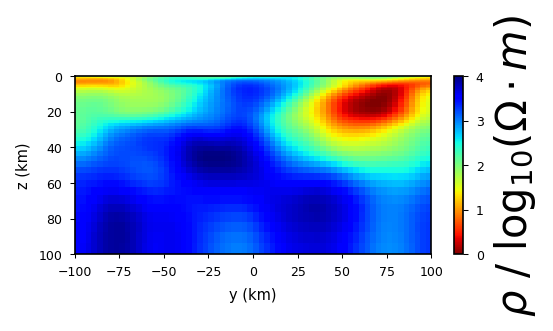

In [ ]:
rho_id = 17 # 5,6,7 is better

n_bins = 5 # number of ticks in colorbar
a_cof = x_normalizer.decode(x)[rho_id, ..., 0].cpu().numpy()
a_cof = np.log10(1/(10**a_cof))
rhoxy = out[rho_id, ...,0].cpu().numpy()
phsxy = -1*out[rho_id, ...,1].cpu().numpy()
rhoyx = out[rho_id, ...,2].cpu().numpy()
phsyx = -1*out[rho_id, ...,3].cpu().numpy()+180
rhoxy_true = y[rho_id, ...,0].cpu().numpy()
phsxy_true = -1*y[rho_id, ...,1].cpu().numpy()
rhoyx_true = y[rho_id, ...,2].cpu().numpy()
phsyx_true = -1*y[rho_id, ...,3].cpu().numpy()+180

rhoxy_10  = out_10[rho_id, ...,0].cpu().numpy()
rhoyx_10  = out_10[rho_id, ...,2].cpu().numpy()
phsxy_10  = -1*out_10[rho_id, ...,1].cpu().numpy()
phsyx_10  = -1*out_10[rho_id, ...,3].cpu().numpy()+180
print("Relative rhoxy,rhoyx, phsxy,phsyx error: ", \
     error_r(rhoxy,rhoxy_true),error_r(rhoyx,rhoyx_true),error_r(phsxy,phsxy_true),error_r(phsyx,phsyx_true),)
# print("Relative rhoxy_100,rhoyx_100, phsx_100y,phsyx_100  error: ", \
#      error_r(rhoxy_100,rhoxy_true),error_r(rhoyx_100,rhoyx_true),error_r(phsyx_100,phsyx_true),error_r(phsyx_100,phsyx_true),)
# print("Relative rhoxy_25,rhoyx_25, phsx_25y,phsyx_25  error: ", \
#      error_r(rhoxy_25,rhoxy_true),error_r(rhoyx_25,rhoyx_true),error_r(phsyx_25,phsyx_true),error_r(phsyx_25,phsyx_true),)
print("Relative rhoxy_10,rhoyx_10, phsx_10y,phsyx_10  error: ", \
     error_r(rhoxy_10,rhoxy_true),error_r(rhoyx_10,rhoyx_true),error_r(phsyx_10,phsyx_true),error_r(phsyx_10,phsyx_true),)
fig = plt.figure(figsize=(10*cm,4*cm))
ax = plt.subplot(1,1,1)
h=ax.pcolormesh(yn/1e3,zn/1e3,a_cof, vmin=0,vmax=4,shading='flat')#,edgecolors='k')
ax.set_xlabel('y (km)')
ax.set_ylabel('z (km)')
ax.invert_yaxis()
cbar = fig.colorbar(h)
cbar.set_label(r"$\rho$ / $\log_{10}(\Omega\cdot m)$",fontsize=20)# ax = plt.subplot(3,2,2)
cbar.ax.locator_params(nbins=n_bins)
# h=ax.pcolormesh(yn/1e3,zn/1e3,x_train0[i,...], shading='flat')
# ax.invert_yaxis()
# fig.colorbar(h)
ax.set_aspect(1)
# plt.savefig("../imags/resisitivety_r"+str(rho_id)+".jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
# plt.savefig("../imags/resisitivety_r"+str(rho_id)+".pdf",dpi=300,bbox_inches='tight',pad_inches=0.05)
# plt.savefig("../imags/resisitivety_r"+str(rho_id)+".jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()


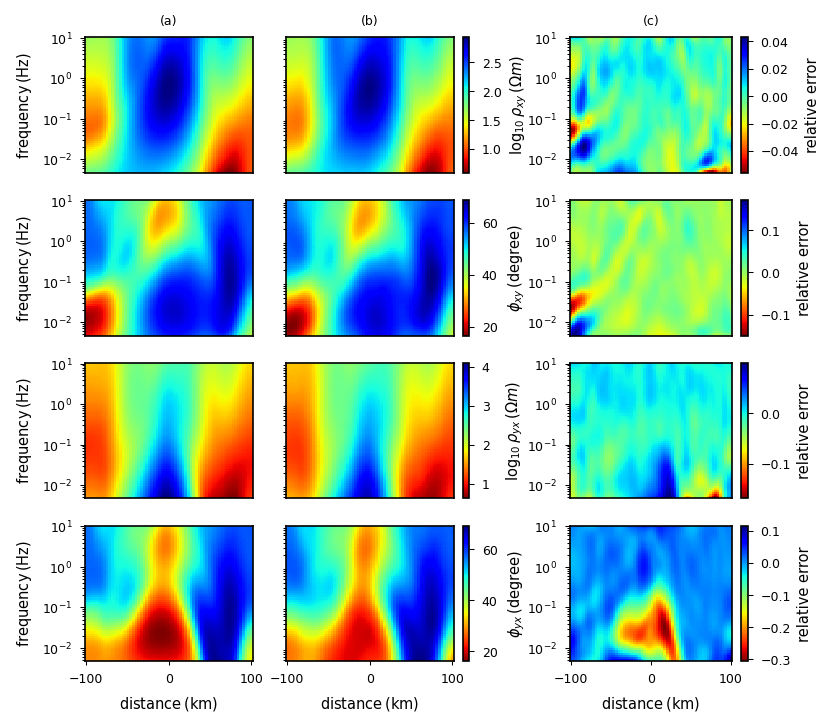

In [ ]:
cm = 1/2.54
obs_id = 35# idx of frequency
f_id = 40# idx of frequency
id_f = 40
n_row,n_column = 4,3
figsize   = (5*n_column*cm,3.5*n_row*cm)
labelpad       = 6 # label pad between label and bar (value is relative to axis value?)  
text_size      = 7 # text size
bar_size       = 7 # label size of colorbar
# for line style
color          = 'white'
linestyle      = 'dashed'
color_f        = 'black'
linestyle_f    = 'solid'
ticks_position = 'bottom' # colorbar ticks location relative to bar
loc            = 'right' # colorbar location relative to map
text_x_pos     = -135 # text location (value is relative to axis data in map)
text_y_pos     = 18.0 
rotation       = 0  # text rotation
shading        = 'nearest' # pcolor shading, nearest for same size of x, y, C.

plt.rcParams['axes.titlesize'] = 6 # font size of the axes title
title_out = ['(a)','(b)','(c)']
# title_out = ['FD',r'22$\times$22','relative error']
# 
bar_label = [r'$\log_{10}\,\rho_{xy}\,(\Omega m)$',r'$\phi_{xy}\,$(degree)',\
             r'$\log_{10}\,\rho_{yx}\,(\Omega m)$',r'$\phi_{yx}\,$(degree)']
x_label   = r'distance$\,$(km)'
y_label   = r'frequency$\,$(Hz)'
rhoxy_error = rhoxy_true-rhoxy_10
phsxy_error = phsxy_true-phsxy_10
rhoyx_error = rhoyx_true-rhoyx_10
phsyx_error = phsyx_true-phsyx_10
data = [[rhoxy_true,rhoxy_10],
        [phsxy_true,phsxy_10],
        [rhoyx_true,rhoyx_10],
        [phsyx_true,phsyx_10]
        ]
data_error=[[rhoxy_error/rhoxy_true],
            [phsxy_error/phsxy_true],
            [rhoyx_error/rhoyx_true],
            [phsyx_error/phsyx_true]]

norm_rhoxy = colors.Normalize(vmin=np.min(data[0]),vmax=np.max(data[0]))
norm_phsxy = colors.Normalize(vmin=np.min(data[1]),vmax=np.max(data[1]))
norm_rhoyx = colors.Normalize(vmin=np.min(data[2]),vmax=np.max(data[2]))
norm_phsyx = colors.Normalize(vmin=np.min(data[3]),vmax=np.max(data[3]))
norm       = [norm_rhoxy,norm_phsxy,norm_rhoyx,norm_phsyx]

ry_row      = [ry[obs_id]/1e3,ry[obs_id]/1e3]
ry_column   = [np.min(ry)/1e3,np.max(ry)/1e3]
freq_row    = [np.min(freq),np.max(freq)]
freq_column = [freq[f_id],freq[f_id]]
ry_f        = ry_column
freq_f      = [freq[id_f],freq[id_f]]

labelpad        = [3,4,7,4] # label pad between label and bar (value is relative to axis value?)  
labelpad_error  = [3,3,3,3] #label pad between label and bar (value is relative to axis value?) 
pad            = 0.02 # pad between colorbar and map (value is relative to figsize?)   

fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        if j!=n_column-1:
            h = ax[i,j].pcolormesh(ry/1e3,freq,data[i][j],norm=norm[i], shading=shading)
#             ax[i,j].plot(ry_row,   freq_row,   color = color,linestyle=linestyle)
#             ax[i,j].plot(ry_column,freq_column,color = color,linestyle=linestyle)
        else: 
            h = ax[i,j].pcolormesh(ry/1e3,freq,data_error[i][0], shading=shading)
            
        ax[i,j].set_yscale("log")
        
        

        if i == 0:
            ax[i,j].set_title(title_out[j])
#             text(text_x_pos,text_y_pos,title_out[j], horizontalalignment='center',\
#                          verticalalignment='center',rotation=rotation,fontsize=text_size)
        if i!=n_row-1:
            ax[i,j].set_xticks([])
            
        if j == 0 :
            ax[i,j].yaxis.tick_left()
            ax[i,j].yaxis.set_label_position("left")
            ax[i,j].set_ylabel(y_label)
        elif j==1:
            ax[i,j].set_yticks([])
        
        if j == n_column-2:
            cbar = fig.colorbar(h,ax=[ax[i,jj] for jj in range(n_column-1)],location=loc,pad=pad)
            cbar.set_label(bar_label[i],fontsize=bar_size,labelpad=labelpad[i])
            cbar.ax.xaxis.set_ticks_position(ticks_position)
        elif j==n_column-1:
            cbar = fig.colorbar(h,ax=ax[i,j] ,location=loc,pad=pad+0.025)
            cbar.set_label('relative error',fontsize=bar_size,labelpad=labelpad_error[i])
            cbar.ax.xaxis.set_ticks_position(ticks_position)
            
            
    ax[i,j].set_xlabel(x_label)
    
# plt.savefig("../imags/super_output_error_10_64.jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
# plt.savefig("../imags/super_output_error_10_64.pdf",dpi=300,bbox_inches='tight',pad_inches=0.05)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../imags/super_output_error_64.jpg'

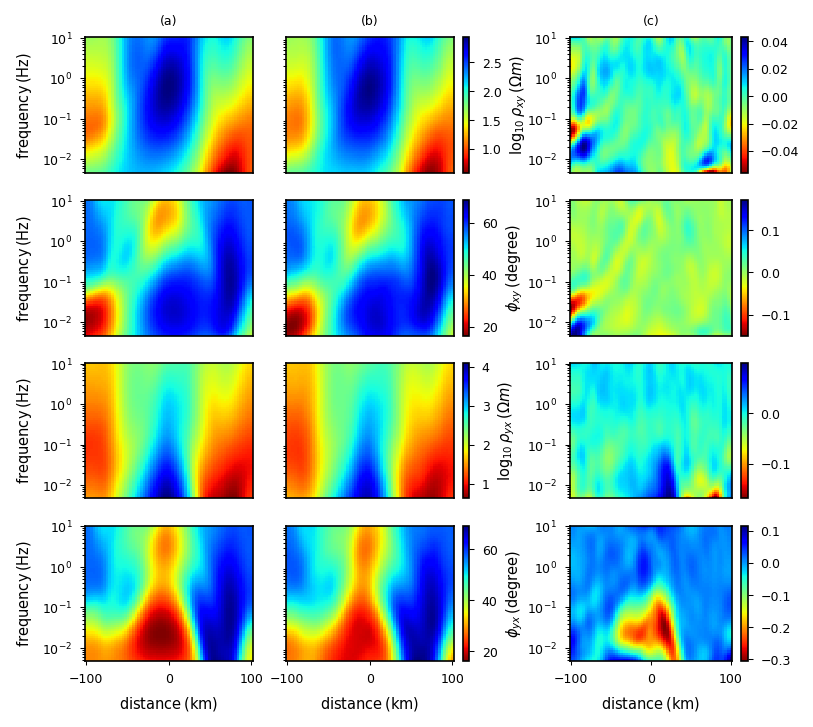

In [ ]:
obs_id = 35# idx of frequency
f_id = 40# idx of frequency
id_f = 40
n_row,n_column = 4,3
figsize   = (5*n_column*cm,3.5*n_row*cm)
labelpad       = 6 # label pad between label and bar (value is relative to axis value?)  
text_size      = 7 # text size
bar_size       = 7 # label size of colorbar
# for line style
color          = 'white'
linestyle      = 'dashed'
color_f        = 'black'
linestyle_f    = 'solid'
ticks_position = 'bottom' # colorbar ticks location relative to bar
loc            = 'right' # colorbar location relative to map
text_x_pos     = -135 # text location (value is relative to axis data in map)
text_y_pos     = 18.0 
rotation       = 0  # text rotation
shading        = 'nearest' # pcolor shading, nearest for same size of x, y, C.

plt.rcParams['axes.titlesize'] = 6 # font size of the axes title
title_out = ['(a)','(b)','(c)']
# title_out = ['FD',r'64$\times$64','relative error']
bar_label = [r'$\log_{10}\,\rho_{xy}\,(\Omega m)$',r'$\phi_{xy}\,$(degree)',\
             r'$\log_{10}\,\rho_{yx}\,(\Omega m)$',r'$\phi_{yx}\,$(degree)']
x_label   = r'distance$\,$(km)'
y_label   = r'frequency$\,$(Hz)'
rhoxy_error = rhoxy_true-rhoxy
phsxy_error = phsxy_true-phsxy
rhoyx_error = rhoyx_true-rhoyx
phsyx_error = phsyx_true-phsyx
data = [[rhoxy_true,rhoxy],
        [phsxy_true,phsxy],
        [rhoyx_true,rhoyx],
        [phsyx_true,phsyx]
        ]
data_error=[[rhoxy_error/rhoxy_true],
            [phsxy_error/phsxy_true],
            [rhoyx_error/rhoyx_true],
            [phsyx_error/phsyx_true]]

norm_rhoxy = colors.Normalize(vmin=np.min(data[0]),vmax=np.max(data[0]))
norm_phsxy = colors.Normalize(vmin=np.min(data[1]),vmax=np.max(data[1]))
norm_rhoyx = colors.Normalize(vmin=np.min(data[2]),vmax=np.max(data[2]))
norm_phsyx = colors.Normalize(vmin=np.min(data[3]),vmax=np.max(data[3]))
norm       = [norm_rhoxy,norm_phsxy,norm_rhoyx,norm_phsyx]

ry_row      = [ry[obs_id]/1e3,ry[obs_id]/1e3]
ry_column   = [np.min(ry)/1e3,np.max(ry)/1e3]
freq_row    = [np.min(freq),np.max(freq)]
freq_column = [freq[f_id],freq[f_id]]
ry_f        = ry_column
freq_f      = [freq[id_f],freq[id_f]]

labelpad        = [3,3,3,3] # label pad between label and bar (value is relative to axis value?)  
labelpad_error  = [2,6,2,9] #label pad between label and bar (value is relative to axis value?) 
pad            = 0.02 # pad between colorbar and map (value is relative to figsize?)   

fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        if j!=n_column-1:
            h = ax[i,j].pcolormesh(ry/1e3,freq,data[i][j],norm=norm[i], shading=shading)
#             ax[i,j].plot(ry_row,   freq_row,   color = color,linestyle=linestyle)
#             ax[i,j].plot(ry_column,freq_column,color = color,linestyle=linestyle)
        else: 
            h = ax[i,j].pcolormesh(ry/1e3,freq,data_error[i][0], shading=shading)
            
        ax[i,j].set_yscale("log")
        
        

        if i == 0:
            ax[i,j].set_title(title_out[j])
#             text(text_x_pos,text_y_pos,title_out[j], horizontalalignment='center',\
#                          verticalalignment='center',rotation=rotation,fontsize=text_size)
        if i!=n_row-1:
            ax[i,j].set_xticks([])
            
        if j == 0 :
            ax[i,j].yaxis.tick_left()
            ax[i,j].yaxis.set_label_position("left")
            ax[i,j].set_ylabel(y_label)
        elif j==1:
            ax[i,j].set_yticks([])
        
        if j == n_column-2:
            cbar = fig.colorbar(h,ax=[ax[i,jj] for jj in range(n_column-1)],location=loc,pad=pad)
            cbar.set_label(bar_label[i],fontsize=bar_size,labelpad=labelpad[i])
            cbar.ax.xaxis.set_ticks_position(ticks_position)
        elif j==n_column-1:
            cbar = fig.colorbar(h,ax=ax[i,j] ,location=loc,pad=pad+0.025)
#             cbar.set_label(bar_label[i],fontsize=bar_size,labelpad=labelpad_error[i])
            cbar.ax.xaxis.set_ticks_position(ticks_position)
            
            
    ax[i,j].set_xlabel(x_label)
    
plt.savefig("../imags/super_output_error_64.jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.savefig("../imags/super_output_error_64.pdf",dpi=300,bbox_inches='tight',pad_inches=0.05)

plt.show()

In [ ]:
title_label = ['FDM',r'64$\times$64',r'16$\times$16']


In [ ]:
plt.rcParams['legend.fontsize']        = 6
plt.rcParams['axes.labelsize']         = 10
title_out = ['(a)','(b)','(c)']
# title_label = ['exact','half-retrain','retrain']

n_row,n_column = 4,2
figsize   = (6*n_column*cm,3*n_row*cm)
linewidth = 1
text_x_pos     = -140 # text location (value is relative to axis data in map)
text_x_pos1     = 40 # text location (value is relative to axis data in map)
text_y_pos     = 4.2 

y_label = [r'$\log_{10}\,\rho_{xy}\,(\Omega m)$',\
           r"$\phi_{xy}\,$(degree)",\
           r'$\log_{10}\,\rho_{yx}\,(\Omega m)$',\
           r"$\phi_{yx}\,$(degree)"]
x_label = [r"distance$\,$(km)",r"frequency$\,$(Hz)"]
title   = ['xy mode','yx mode']



# rho_min = np.min([rhoxy_x_true,rhoxy_x,rhoyx_x_true,rhoyx_x])
# rho_max = np.max([rhoxy_x_true,rhoxy_x,rhoyx_x_true,rhoyx_x])
# phs_min = np.min([phsxy_x_true,phsxy_x,phsyx_x_true,phsyx_x])
# phs_max = np.max([phsxy_x_true,phsxy_x,phsyx_x_true,phsyx_x])
# rho_lim = [rho_min,rho_max]
# phs_lim = [phs_min,phs_max]
rho_ticks  = [0,1.0,2.0,3.0,4.0]
rho_lim = [0,4.0]
phs_lim = [0,90]

print(f"frequency is: {freq[f_id]} Hz")
print("")

# rho_min = np.min([rhoxy_true,rhoxy,rhoyx_true,rhoyx])
# rho_max = np.max([rhoxy_true,rhoxy,rhoyx_true,rhoyx])
# phs_min = np.min([phsxy_true,phsxy,phsyx_true,phsyx])
# phs_max = np.max([phsxy_true,phsxy,phsyx_true,phsyx])
# rho_lim = [rho_min,rho_max]
# phs_lim = [phs_min,phs_max]
data0   = [[rhoxy_true[f_id,:],   phsxy_true[f_id,:],  rhoyx_true[f_id,:],  phsyx_true[f_id,:]],
            [rhoxy_true[:,obs_id],phsxy_true[:,obs_id],rhoyx_true[:,obs_id],phsyx_true[:,obs_id]]]
data1   = [[rhoxy[f_id,:],  phsxy[f_id,:],  rhoyx[f_id,:],  phsyx[f_id,:]],
           [rhoxy[:,obs_id],phsxy[:,obs_id],rhoyx[:,obs_id],phsyx[:,obs_id]]]
data2   = [[rhoxy_10[f_id,:],  phsxy_10[f_id,:],  rhoyx_10[f_id,:],  phsyx_10[f_id,:]],
           [rhoxy_10[:,obs_id],phsxy_10[:,obs_id],rhoyx_10[:,obs_id],phsyx_10[:,obs_id]]]

print(f"observation station is: {ry[obs_id]/1e3}km")
print("")
fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        if j == 0:
            ax[i,j].scatter(ry/1e3, data0[j][i],color='None',marker='o',s=2,edgecolors='g',             label=title_label[0])     
            ax[i,j].plot(   ry/1e3, data1[j][i],color='r', linewidth=linewidth,linestyle='solid', marker='None',markersize=1,label=title_label[1])
            ax[i,j].plot(   ry/1e3, data2[j][i],color='b', linewidth=linewidth,linestyle='solid', marker='None',markersize=1,label=title_label[2])            
#             ax[i,j].set_ylabel(y_label[i])
            if i%2==0:
                ax[i,j].set_ylabel(y_label[i])
            else:
                ax[i,j].set_ylabel(y_label[i],labelpad=1)


#         ax[i,jj].plot(   freq, data2[i][j],color='b', linestyle='solid', marker='None',markersize=1,label=title_label[2])
        elif j==1:
            ax[i,j].scatter(freq, data0[j][i],color='None',marker='o',s=2,edgecolors='g',             label=title_label[0])     
            ax[i,j].plot(   freq, data1[j][i],color='r', linewidth=linewidth,linestyle='solid', marker='None',markersize=1,label=title_label[1])
            ax[i,j].plot(   freq, data2[j][i],color='b', linewidth=linewidth,linestyle='solid', marker='None',markersize=1,label=title_label[2])
            ax[i,j].invert_xaxis()
            ax[i,j].set_xscale("log")       
        
        ax[i,j].tick_params(axis='both',which='major',length=2, width=1,direction='in')
        ax[i,j].tick_params(axis='both',which='minor',length=1, width=1,direction='in')
        
                
        if i == 0:
            ax[i,j].set_title(title_out[j])
#             (text_x_pos1,text_y_pos,title_out[j], horizontalalignment='center',\
#                                      verticalalignment='center',rotation=rotation,fontsize=text_size)            
            ax[i,j].set_ylim(rho_lim)
            ax[i,j].set_yticks(rho_ticks)
#             ax[i,j].set_title(title[0])
            
#             ax[i,j].set_aspect(1) # same scale
#             ax[i,j].legend()
        elif i == 1:
            ax[i,j].set_ylim(phs_lim)
        elif i == 2:
            ax[i,j].set_ylim(rho_lim)
            ax[i,j].set_yticks(rho_ticks)
#             ax[i,j].set_title(title[1])
        elif i == 3:
            ax[i,j].set_xlabel(x_label[j])           
            ax[i,j].set_ylim(phs_lim)
            
ax[0,1].legend(loc='upper left')
fig.tight_layout()#调整整体空白
plt.subplots_adjust(wspace =0.2, hspace =0.2)#调整子图间距
# plt.savefig("../imags/freq_profile_r"+str(rho_id)+"_o"+str(obs_id)+".jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
# plt.savefig("../imags/input_128_profile.eps",bbox_inches='tight',pad_inches=0.05)
# plt.savefig("../imags/input_128_profile.pdf",dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.savefig("../imags/freq_profile_r"+str(rho_id)+"_o"+str(obs_id)+".jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()            

In [ ]:
n_row,n_column = 2,2
figsize   = (12,8)

y_label = [r'$\rho_a$ / $\log_{10}(\Omega\cdot m)$',r"$\phi$ / degree"]
title   = ['TE mode','TM mode']
x_label = "frequency (Hz)"
rho_min = np.min([rhoxy_true,rhoxy,rhoyx_true,rhoyx])
rho_max = np.max([rhoxy_true,rhoxy,rhoyx_true,rhoyx])
phs_min = np.min([phsxy_true,phsxy,phsyx_true,phsyx])
phs_max = np.max([phsxy_true,phsxy,phsyx_true,phsyx])
# rho_lim = [rho_min,rho_max]
# phs_lim = [phs_min,phs_max]
data0   = [[rhoxy_true[:,obs_id],rhoyx_true[:,obs_id]],[phsxy_true[:,obs_id],phsyx_true[:,obs_id]]]
data1   = [[rhoxy[:,obs_id],rhoyx[:,obs_id]],[phsxy[:,obs_id],phsyx[:,obs_id]]]
data2   = [[rhoxy_10[:,obs_id],rhoyx_10[:,obs_id]],[phsxy_10[:,obs_id],phsyx_10[:,obs_id]]]

print(f"observation station is: {ry[obs_id]/1e3}km")
print("")
fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        ax[i,j].scatter(freq, data0[i][j],color='None',marker='o',s=40,edgecolors='g',             label=title_label[0])
        ax[i,j].plot(   freq, data1[i][j],color='r', linestyle='solid', marker='None',markersize=1,label=title_label[1])
        ax[i,j].plot(   freq, data2[i][j],color='b', linestyle='solid', marker='None',markersize=1,label=title_label[2])
        
        ax[i,j].invert_xaxis()
        ax[i,j].set_xscale("log")
        ax[i,j].tick_params(axis='both',which='major',length=5, width=2,direction='in')
        ax[i,j].tick_params(axis='both',which='minor',length=3, width=1.5,direction='in')
        if j==0:
            ax[i,j].set_ylabel(y_label[i])
        if i == 0:
            ax[i,j].set_title(title[j])
            ax[i,j].set_ylim(rho_lim)
#             ax[i,j].set_aspect(1) # same scale
#             ax[i,j].legend()
        elif i == n_row-1:
            ax[i,j].set_xlabel(x_label)           
            ax[i,j].set_ylim(phs_lim)
        ax[0,0].legend(loc='upper left')
fig.tight_layout()#调整整体空白
plt.subplots_adjust(wspace =0.1, hspace =0.15)#调整子图间距
# plt.savefig("../imags/freq_profile_r"+str(rho_id)+"_o"+str(obs_id)+".jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.savefig("../imags/freq_profile_r"+str(rho_id)+"_o"+str(round(ry[obs_id],3))+".pdf",bbox_inches='tight',pad_inches=0.05)
plt.show()        